In [1]:
import numpy as np
import os
import scipy.io as scio
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from tqdm import tqdm
from tqdm.auto import trange
from matplotlib import colors
import argparse
import sys
sys.path.append("/media/miplab-nas2/Data3/Danyang/Multi-Echo-BOLD_fingerprinting")

from fingerprinting.load_data import load_data_split
from fingerprinting.pca_denoising import pca_denoising
from fingerprinting.draw_results import *
from fingerprinting.ICC import calculate_ICC
from fingerprinting.utils import *
from fingerprinting.utils_identifiability import *

/home/dawang/.conda/envs/dawang/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path='./data0'
result_path='./fingerprinting/results_speedup_test'
subjects_num=-1
if_icc=False
if_save_FC=False

echoes_total_num = 5  # including optimal combination
echo_optcomb = echoes_total_num - 1 # the last echo is the optcomb
subjects_total_num = int(len(os.listdir(data_path)) / (echoes_total_num)) # there is another optimal TS.
if subjects_num == -1:
    subjects_num = subjects_total_num
print("There are " + str(subjects_total_num) + " subjects with " + str(echoes_total_num) + " echoes (include 1 optcomb).")

# Load data
TCs_test, TCs_retest, FCs_test, FCs_retest, orig_matrixs_test, orig_matrixs_retest = load_data_split(data_path, subjects_num, echoes_total_num)
TCs = np.concatenate((TCs_test, TCs_retest), axis=3)

There are 84 subjects with 5 echoes (include 1 optcomb).


In [3]:
# for echo_test in tqdm(range(echoes_total_num), desc='echo1', leave=False): # Another echo_index: for optimal combination.
#     for echo_retest in tqdm(range(echoes_total_num), desc='echo2', leave=False):
ICC_matrices = []
ICC_matrices_opt = []
for echo_test in tqdm(range(echoes_total_num), desc='echo1', leave=False):
    echo_retest = echo_test
    FC_list_test = orig_matrixs_test[echo_test].T
    FC_list_retest = orig_matrixs_retest[echo_retest].T
    FCs = np.stack((FC_list_test,FC_list_retest), axis=1)
    ICC_matrix = compute_ICC_idenfiability_from_single_FCs(FCs)
    ICC_matrices.append(ICC_matrix)

    list_Idiff = compute_Idiff_PCA_two_datasets_from_FCs(FC_list_test, FC_list_retest)
    Idiff_opt = np.max(list_Idiff[:,1])
    m_star = int(list_Idiff[np.where(list_Idiff[:,1] == Idiff_opt)[0][0], 0])
    FC_list_test_opt, FC_list_retest_opt = compute_FCs_PCA_opt_two_datasets_from_FCs(FC_list_test,FC_list_retest,m_star)

    FCs_opt = np.stack((FC_list_test_opt,FC_list_retest_opt), axis=1)
    ICC_matrix_opt = compute_ICC_idenfiability_from_single_FCs(FCs_opt)
    ICC_matrices_opt.append(ICC_matrix_opt)
ICC_matrices = np.array(ICC_matrices)
ICC_matrices_opt = np.array(ICC_matrices_opt)


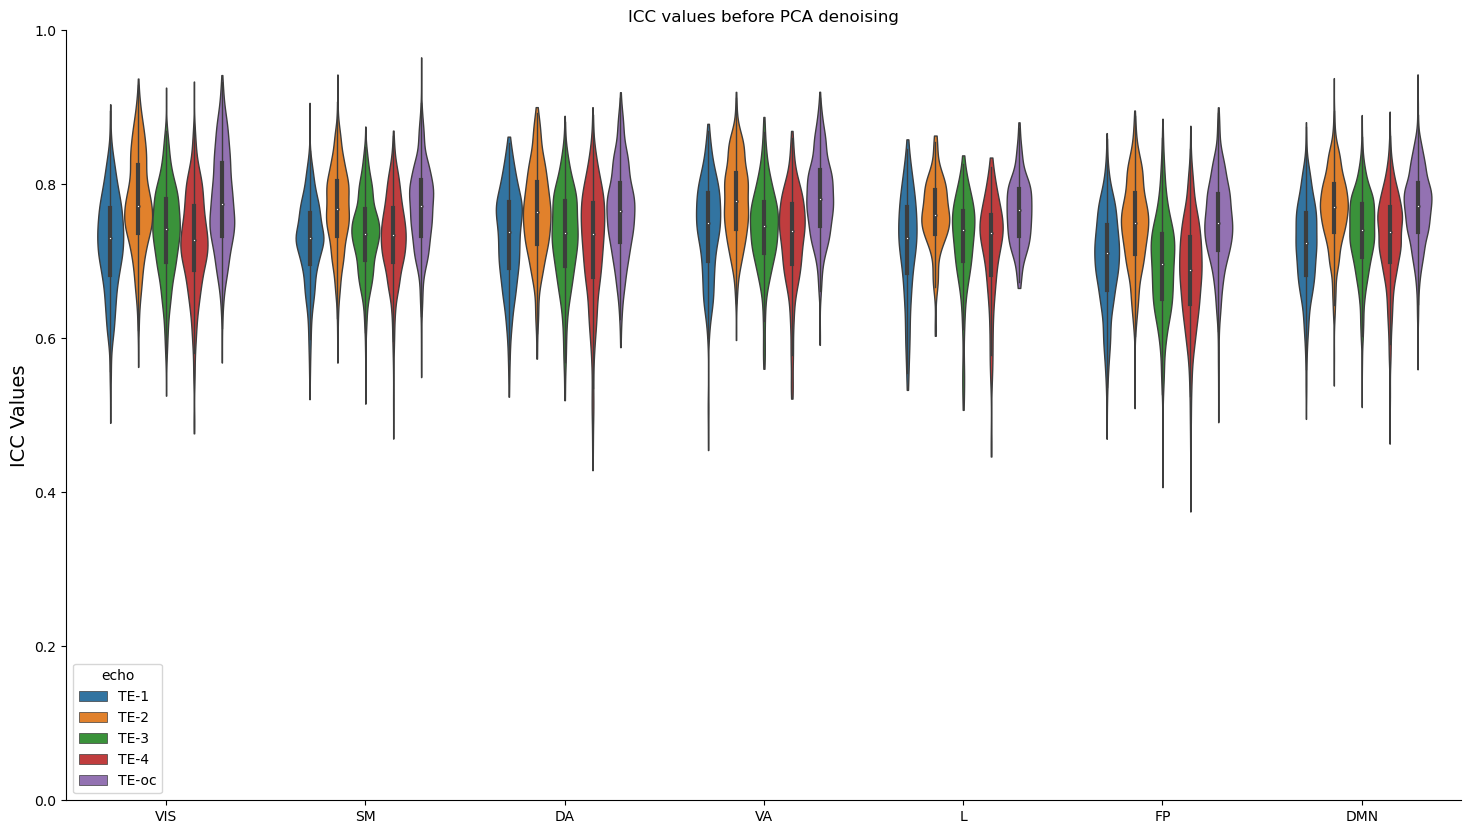

In [16]:
yeoOrder,limit_yeo = load_yeonets_matfile("/media/miplab-nas2/Data3/Danyang/Multi-Echo-BOLD_fingerprinting/yeo_RS7_Schafer200S.mat")
fig = plt.figure(dpi=100, figsize=(18,10))
ax1 = plt.subplot(111)
plot_ICCs_violins(ICC_matrices, yeoOrder=yeoOrder,limit_yeo=limit_yeo, ax=ax1, title="ICC values before PCA denoising")


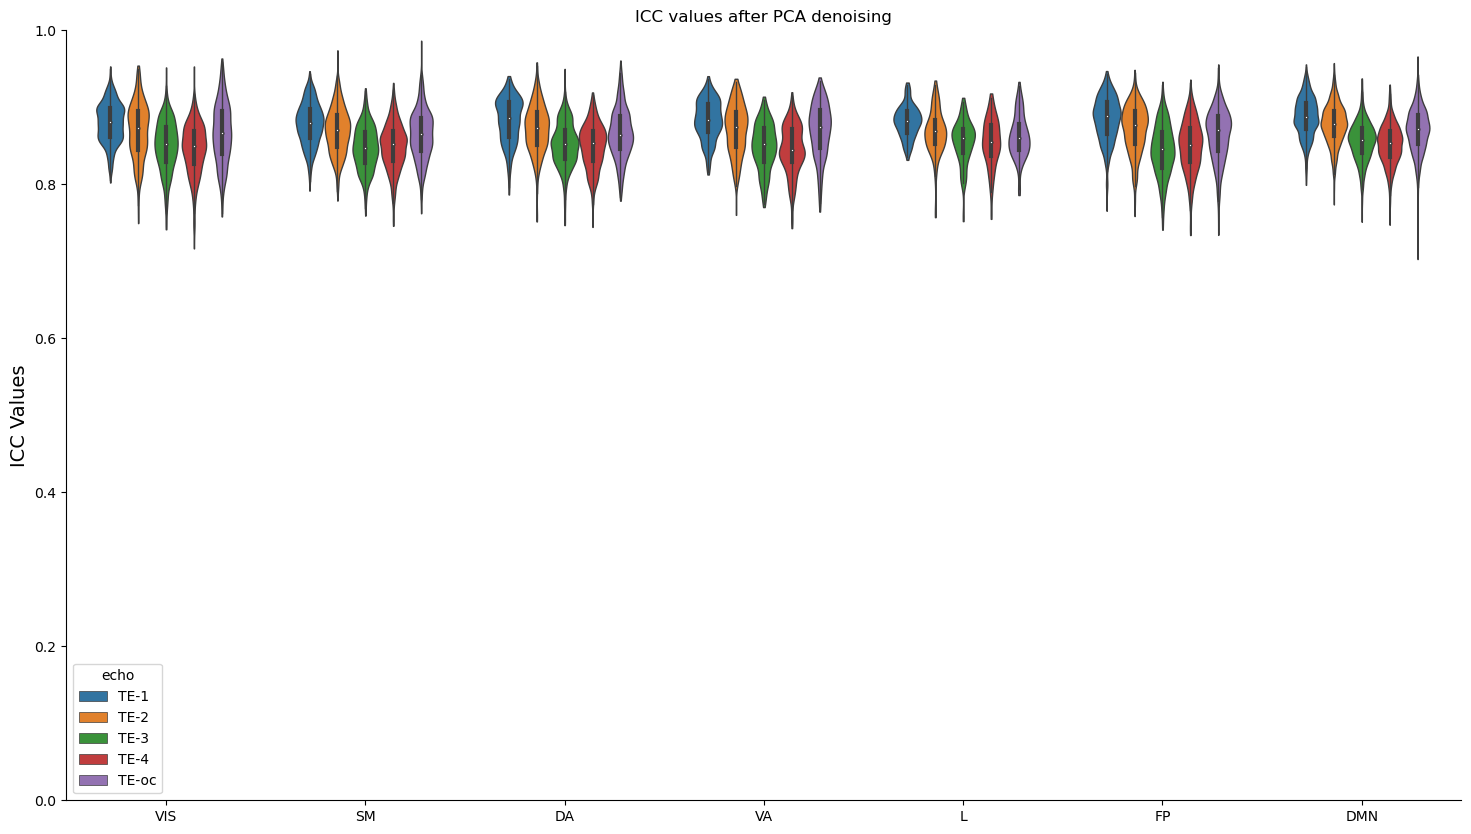

In [17]:
fig = plt.figure(dpi=100, figsize=(18,10))
ax2 = plt.subplot(111)
plot_ICCs_violins(ICC_matrices_opt, yeoOrder=yeoOrder,limit_yeo=limit_yeo, ax=ax2, title="ICC values after PCA denoising")
            

In [11]:
TCs = np.concatenate((TCs_test, TCs_retest), axis=3)
TCs = TCs[:,3,:,:]
FCs = []
for echo in range(5):
    FCs.append(np.corrcoef(TCs[echo])) 
FCs = np.array(FCs)


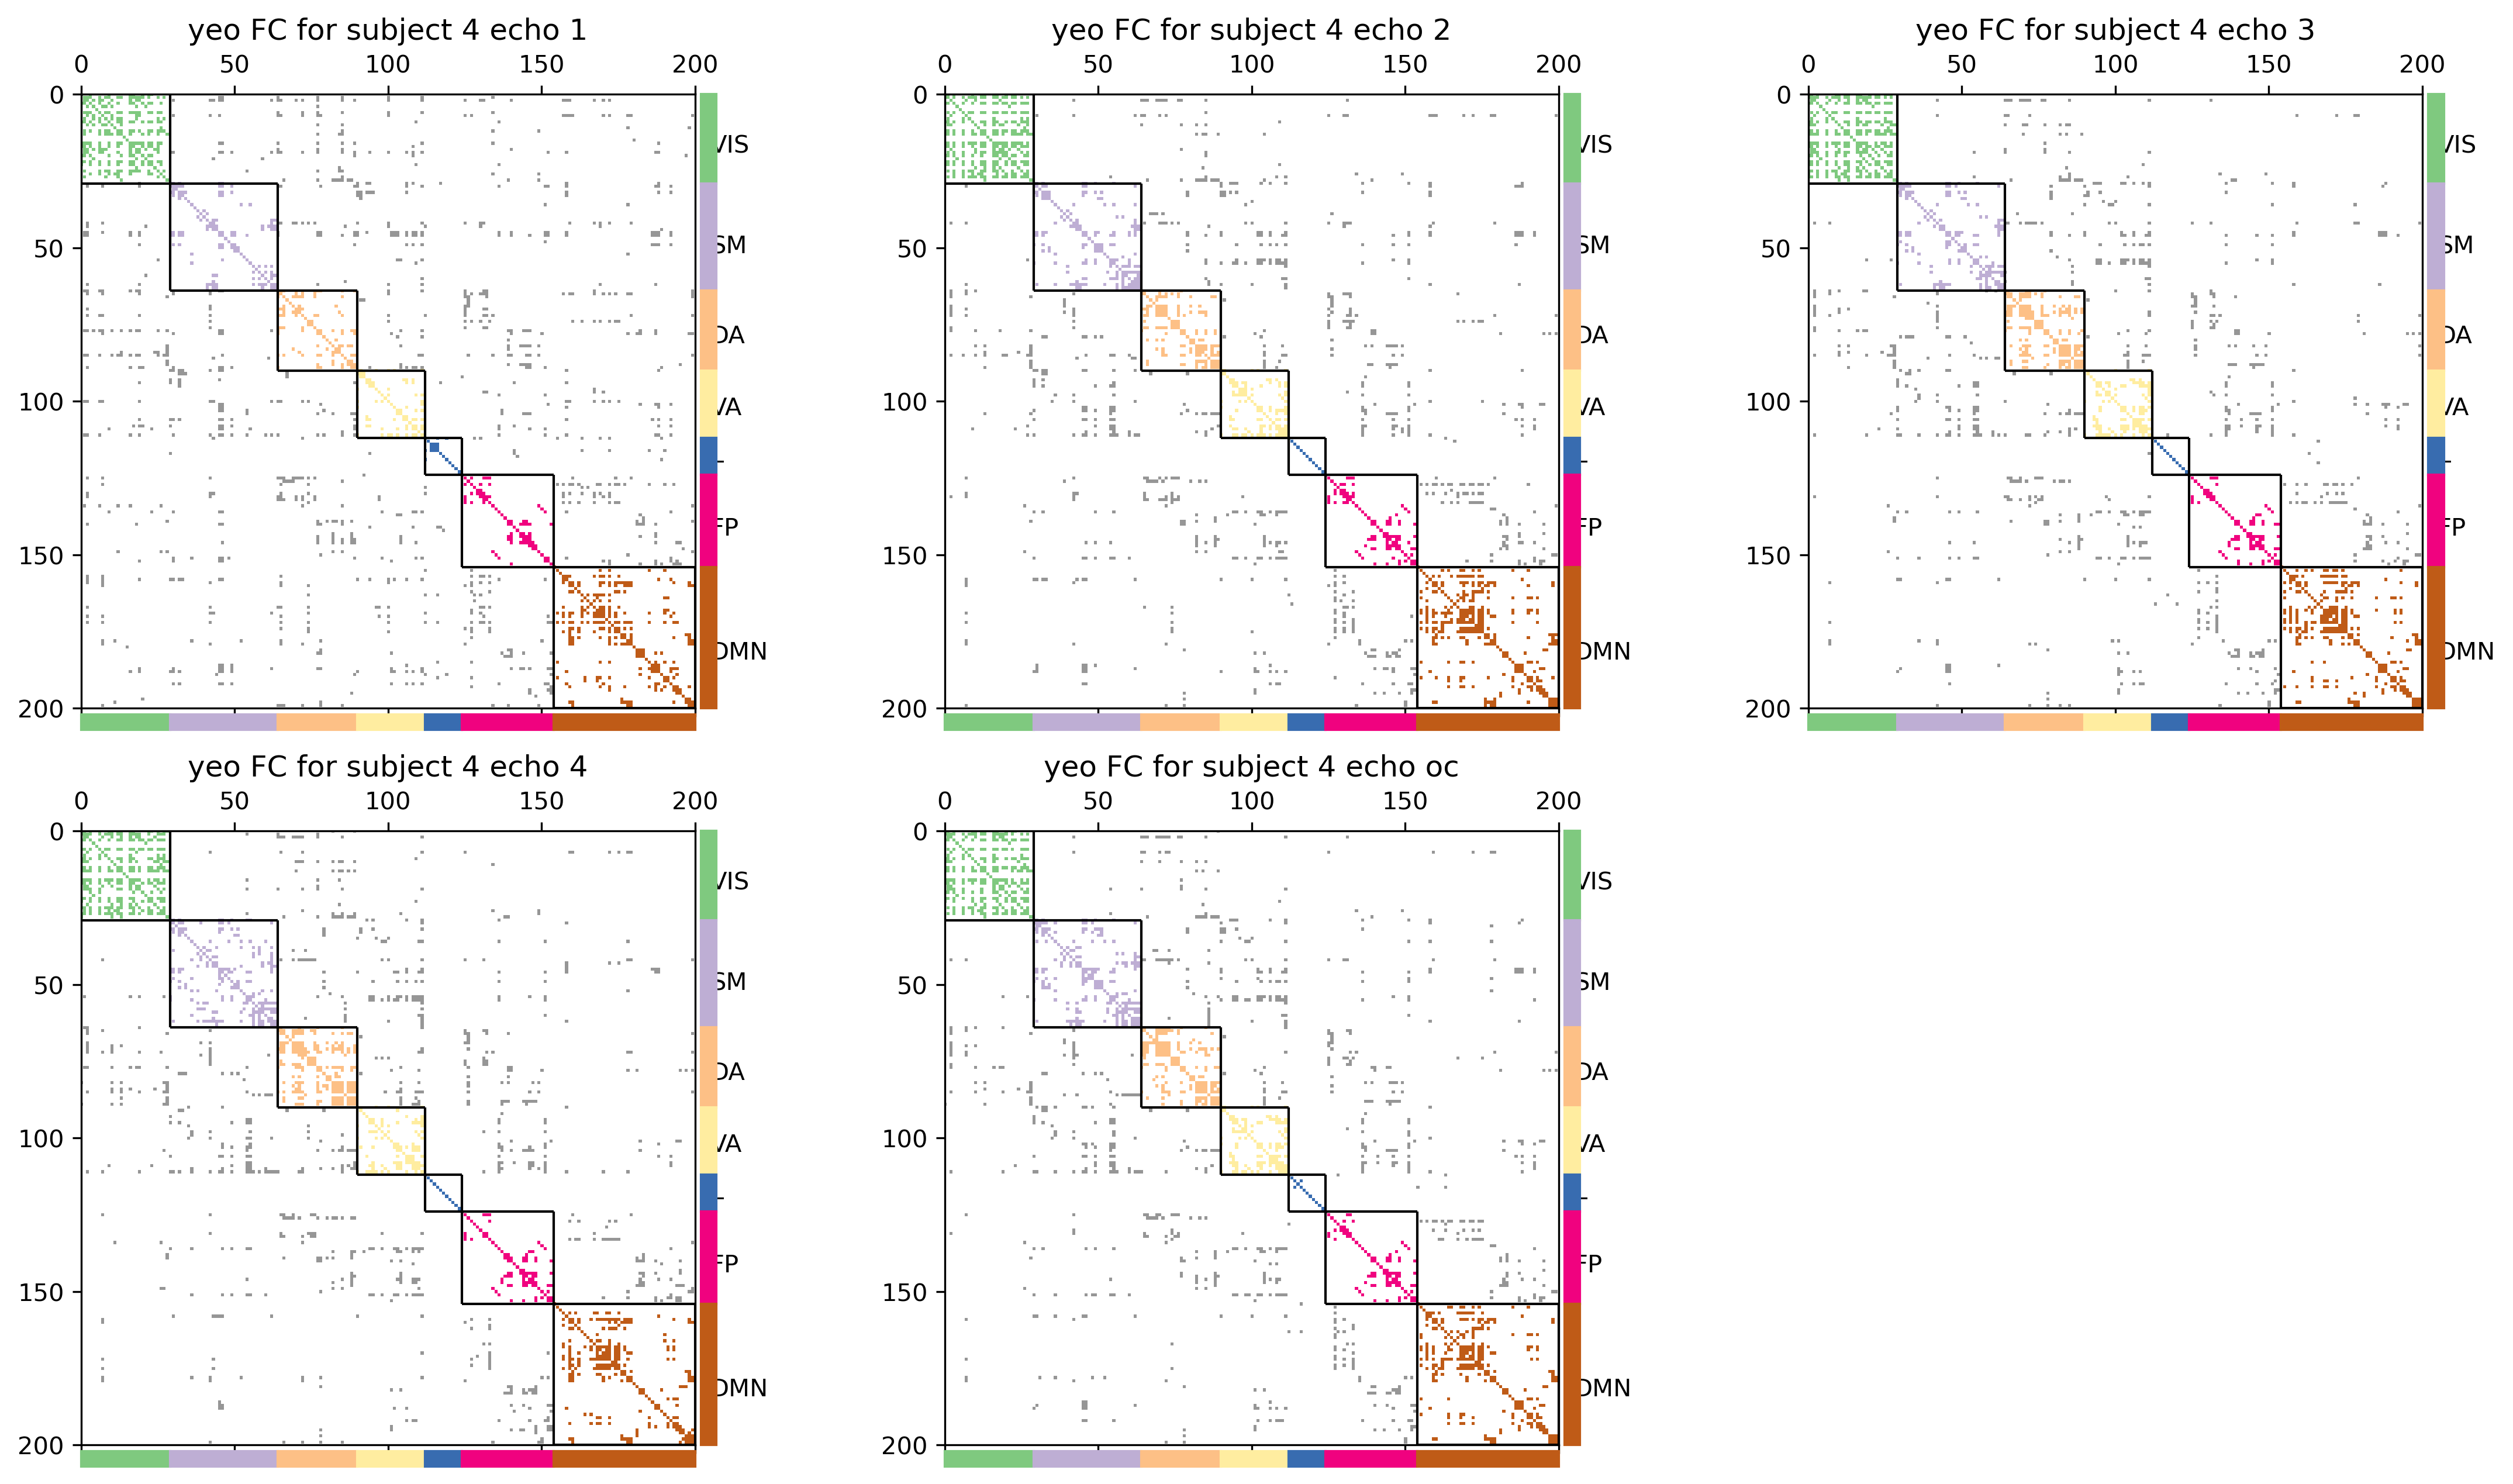

In [12]:
fig = plt.figure(dpi=300,figsize=(18,10))
ax1 = plt.subplot(231)
plot_FC_mat(FCs[0,:200,:200],yeo_net=True, yeoOrder=yeoOrder, limit_yeo=limit_yeo, ax=ax1, title="yeo FC for subject 4 echo 1")

ax2 = plt.subplot(232)
plot_FC_mat(FCs[1,:200,:200],yeo_net=True, yeoOrder=yeoOrder, limit_yeo=limit_yeo, ax=ax2, title="yeo FC for subject 4 echo 2")

ax3 = plt.subplot(233)
plot_FC_mat(FCs[2,:200,:200],yeo_net=True, yeoOrder=yeoOrder, limit_yeo=limit_yeo, ax=ax3, title="yeo FC for subject 4 echo 3")

ax4 = plt.subplot(234)
plot_FC_mat(FCs[3,:200,:200],yeo_net=True, yeoOrder=yeoOrder, limit_yeo=limit_yeo, ax=ax4, title="yeo FC for subject 4 echo 4")

ax5 = plt.subplot(235)
plot_FC_mat(FCs[4,:200,:200],yeo_net=True, yeoOrder=yeoOrder, limit_yeo=limit_yeo, ax=ax5, title="yeo FC for subject 4 echo oc")


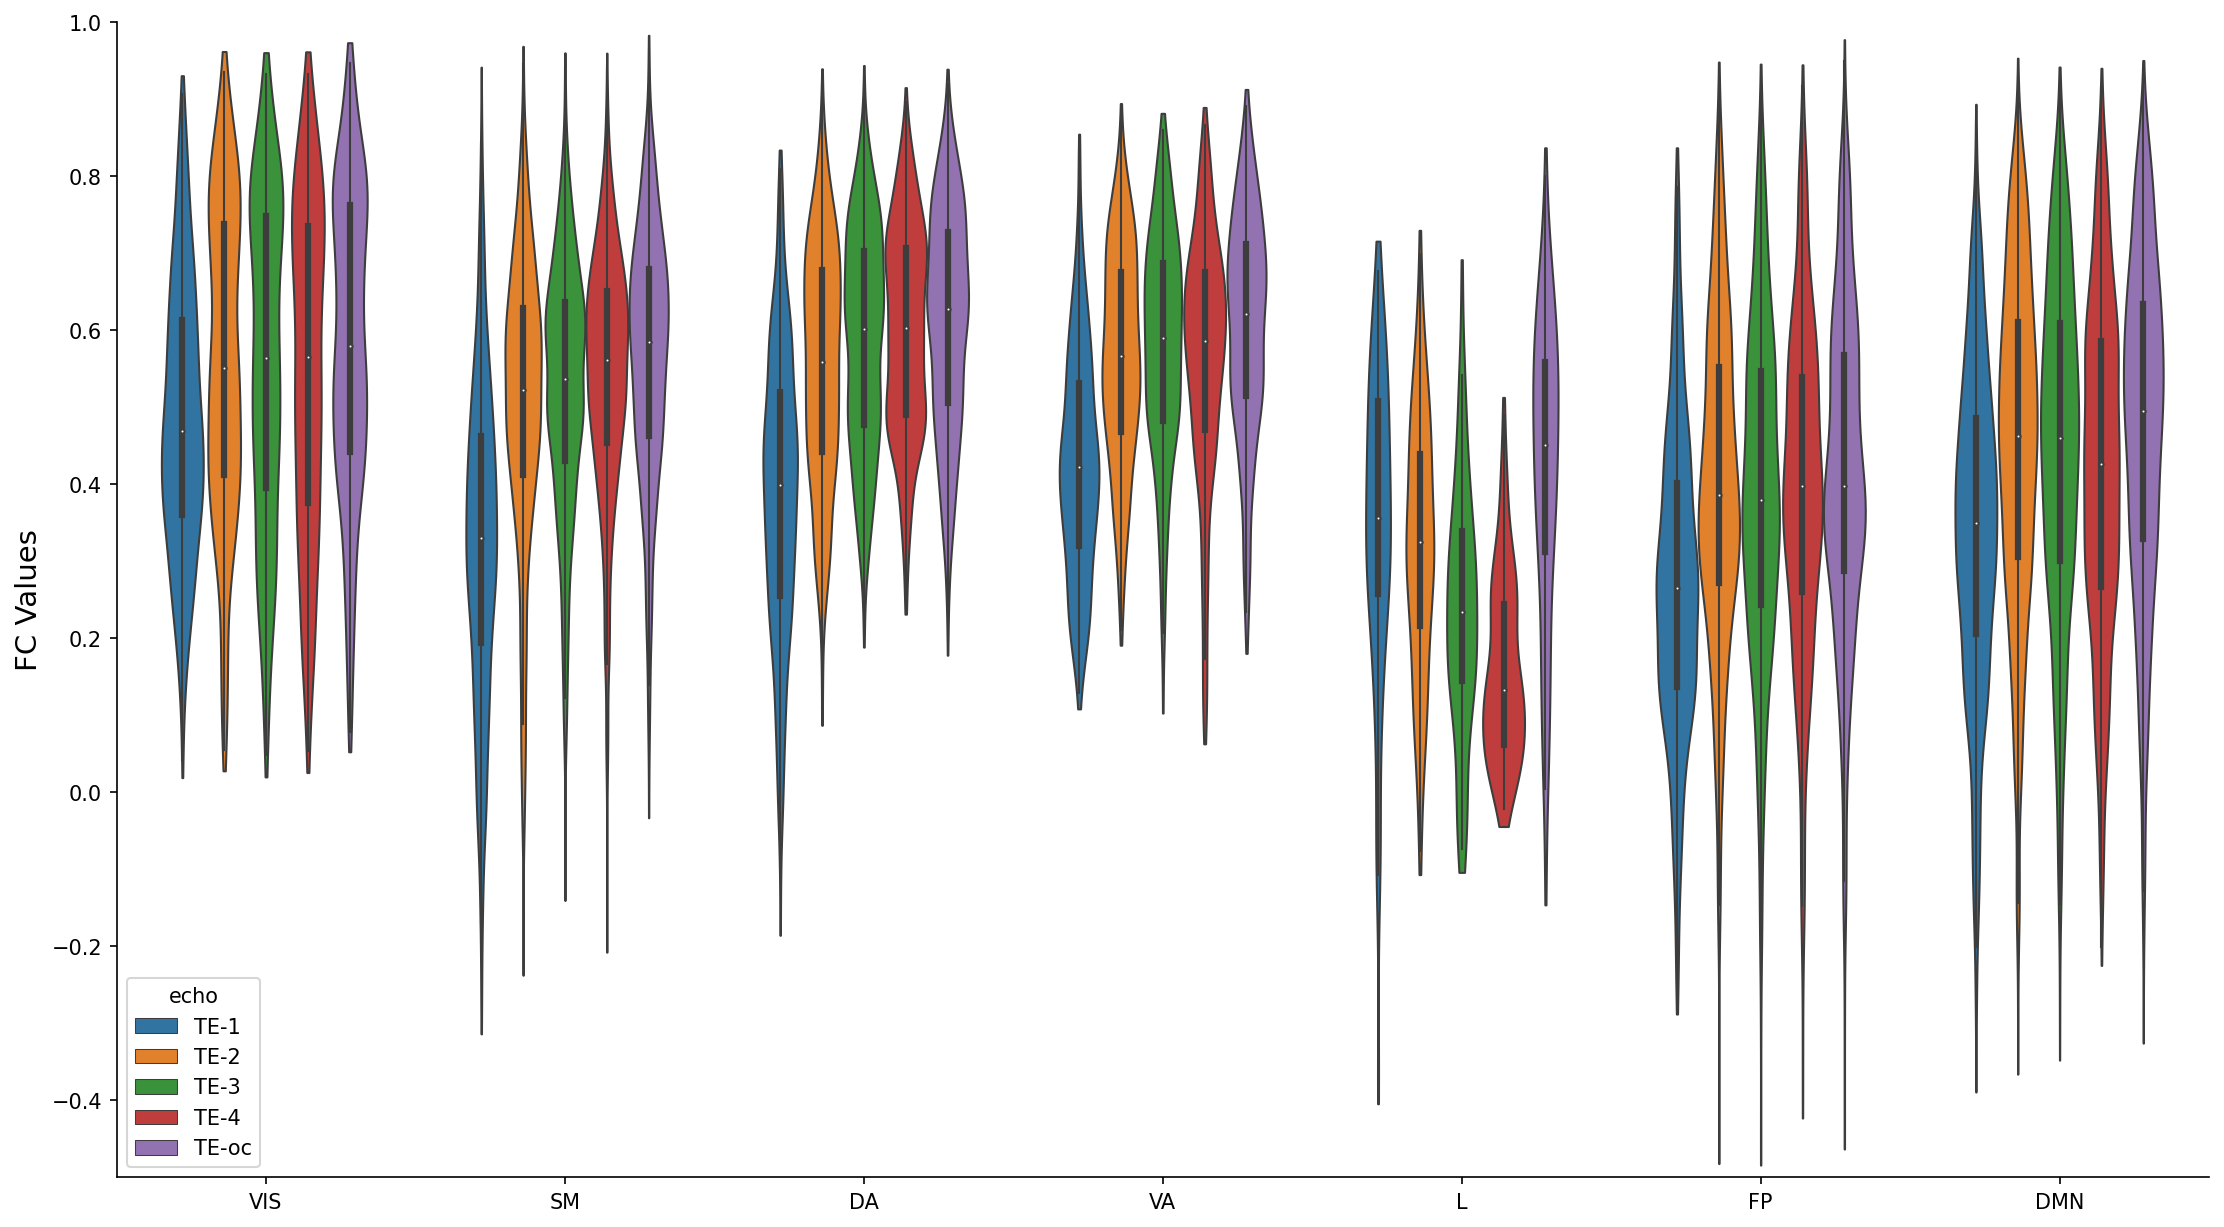

In [13]:
fig = plt.figure(dpi=150,figsize=(18,10))
ax1 = plt.subplot(111)
plot_FCs_violins(FCs,yeoOrder,limit_yeo,ax=ax1)

In [3]:
TCs_3 = TCs[:,3]
CNRs = []
for i in range(5):
    TCi = TCs_3[i]
    CNRi = compute_CNRs(TCi, TCi)
    CNRs.append(CNRi)

CNRs = np.array(CNRs)

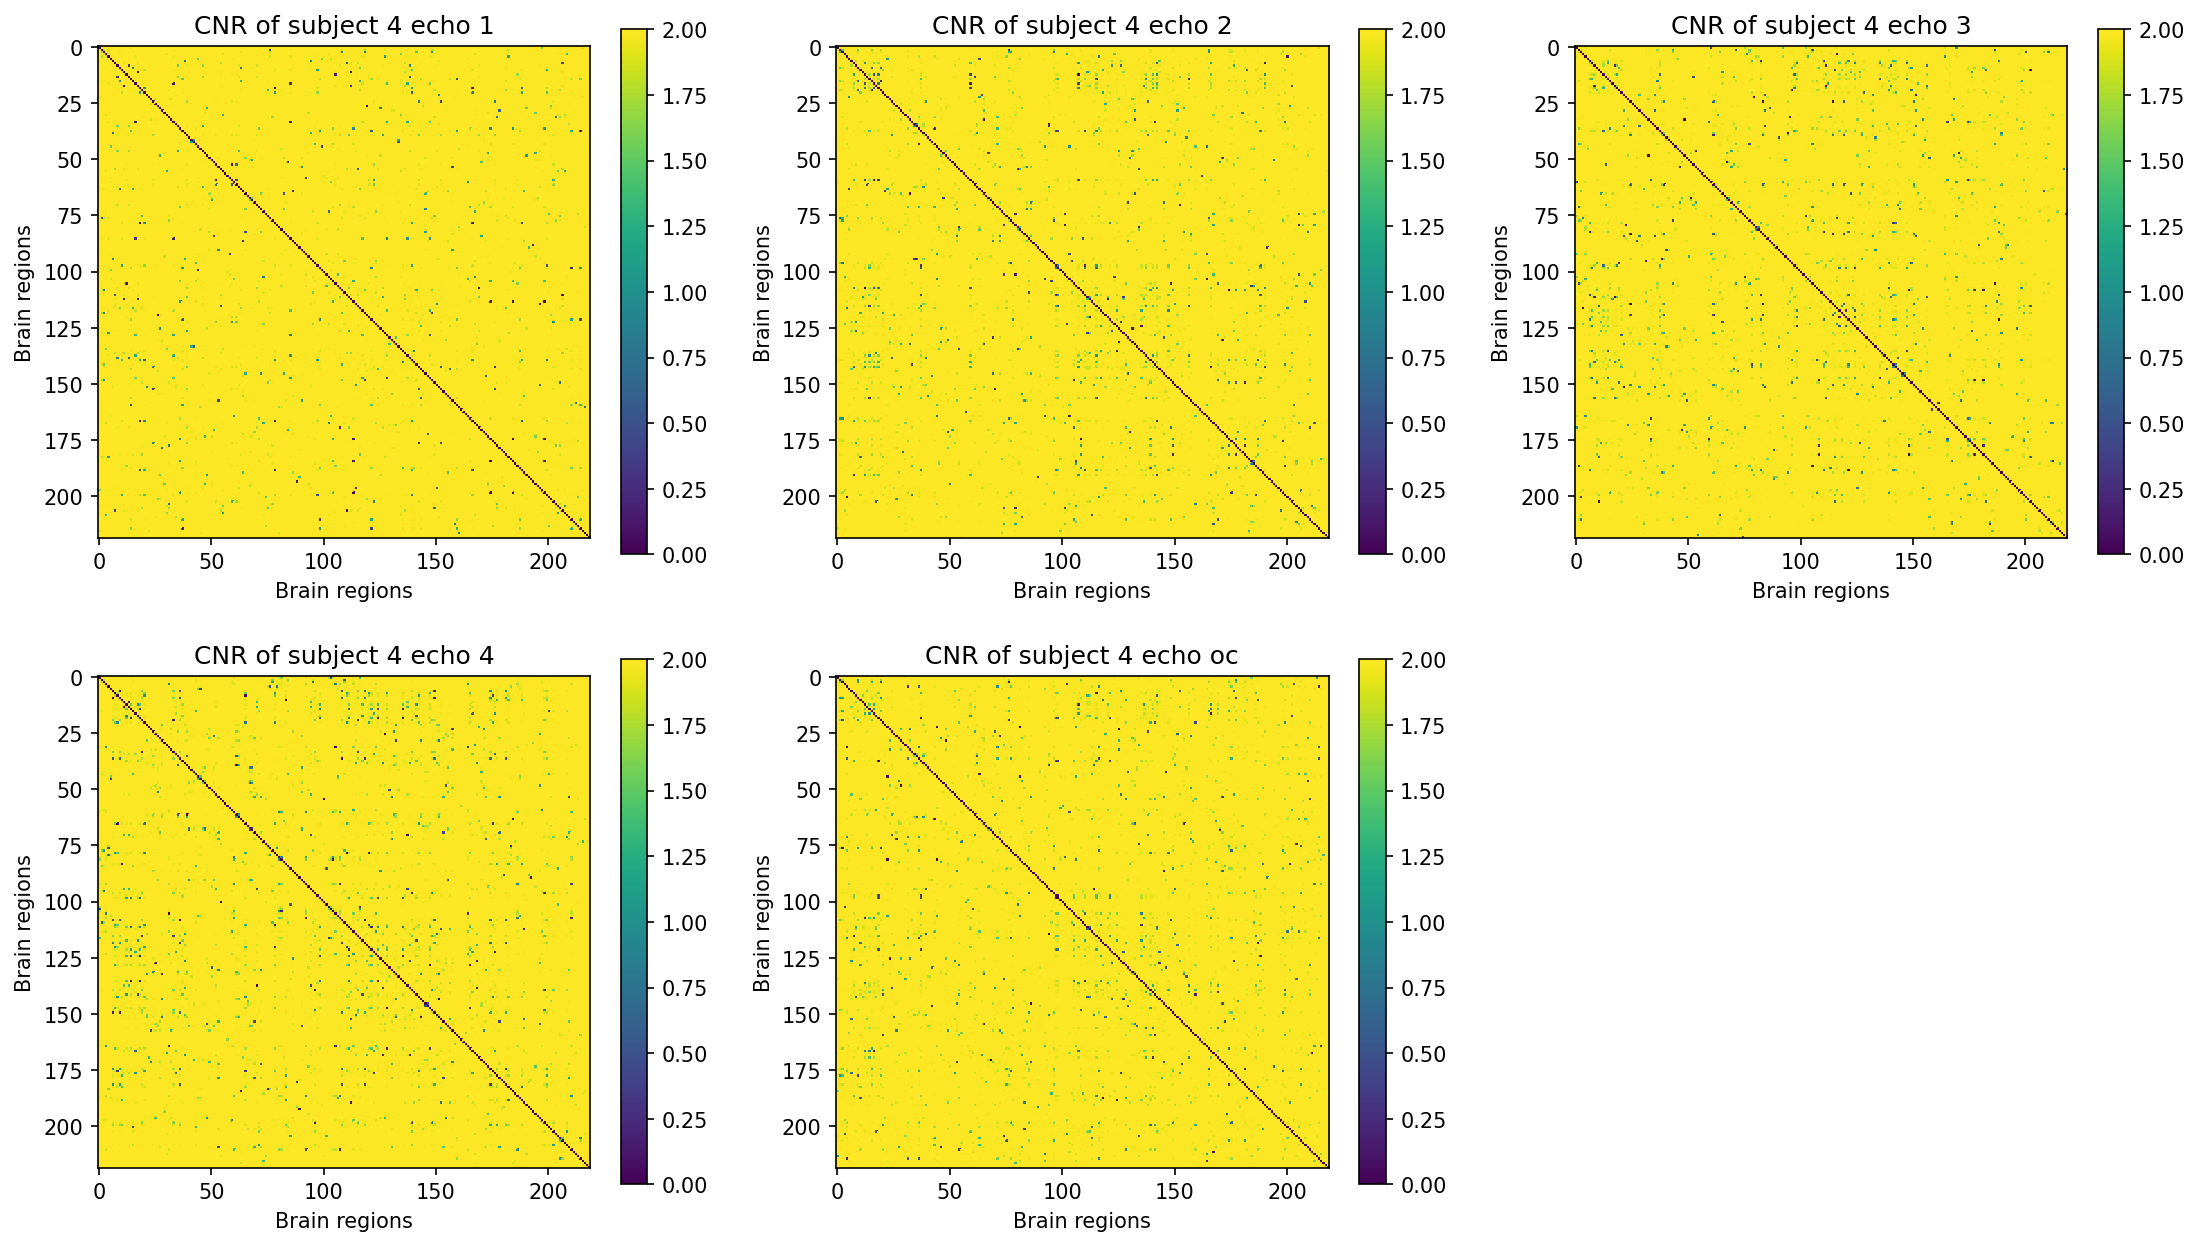

In [5]:
fig = plt.figure(dpi=150,figsize=(18,10))
plt.subplot(231)
plt.title("CNR of subject 4 echo 1")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs[0], vmin=0, vmax=2)
plt.colorbar()
plt.imshow(CNRs[0])

plt.subplot(232)
plt.title("CNR of subject 4 echo 2")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs[1], vmin=0, vmax=2)
plt.colorbar()
plt.imshow(CNRs[1])

plt.subplot(233)
plt.title("CNR of subject 4 echo 3")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs[2], vmin=0, vmax=2)
plt.colorbar()
plt.imshow(CNRs[2])

plt.subplot(234)
plt.title("CNR of subject 4 echo 4")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs[3], vmin=0, vmax=2)
plt.colorbar()
plt.imshow(CNRs[3])

plt.subplot(235)
plt.title("CNR of subject 4 echo oc")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs[4], vmin=0, vmax=2)
plt.colorbar()
plt.imshow(CNRs[4])

plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs[0], vmin=0, vmax=2)
plt.colorbar()
plt.imshow(CNRs[0])

plt.subplot(232)
plt.title("CNR of subject 4 echo 2")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs[1], vmin=0, vmax=2)
plt.colorbar()
plt.imshow(CNRs[1])

plt.subplot(233)
plt.title("CNR of subject 4 echo 3")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs[2], vmin=0, vmax=2)
plt.colorbar()
plt.imshow(CNRs[2])

plt.subplot(234)
plt.title("CNR of subject 4 echo 4")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs[3], vmin=0, vmax=2)
plt.colorbar()
plt.imshow(CNRs[3])

plt.subplot(235)
plt.title("CNR of subject 4 echo oc")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs[4], vmin=0, vmax=2)
plt.colorbar()
plt.imshow(CNRs[4])

In [4]:
CNRs_couple = []
for i in range(5):
    TCi = TCs_3[i]
    for j in range(i+1, 5):        
        TCj = TCs_3[j]
        CNRij = compute_CNRs(TCi, TCj)
        CNRs_couple.append(CNRij)
CNRs_couple = np.array(CNRs_couple)


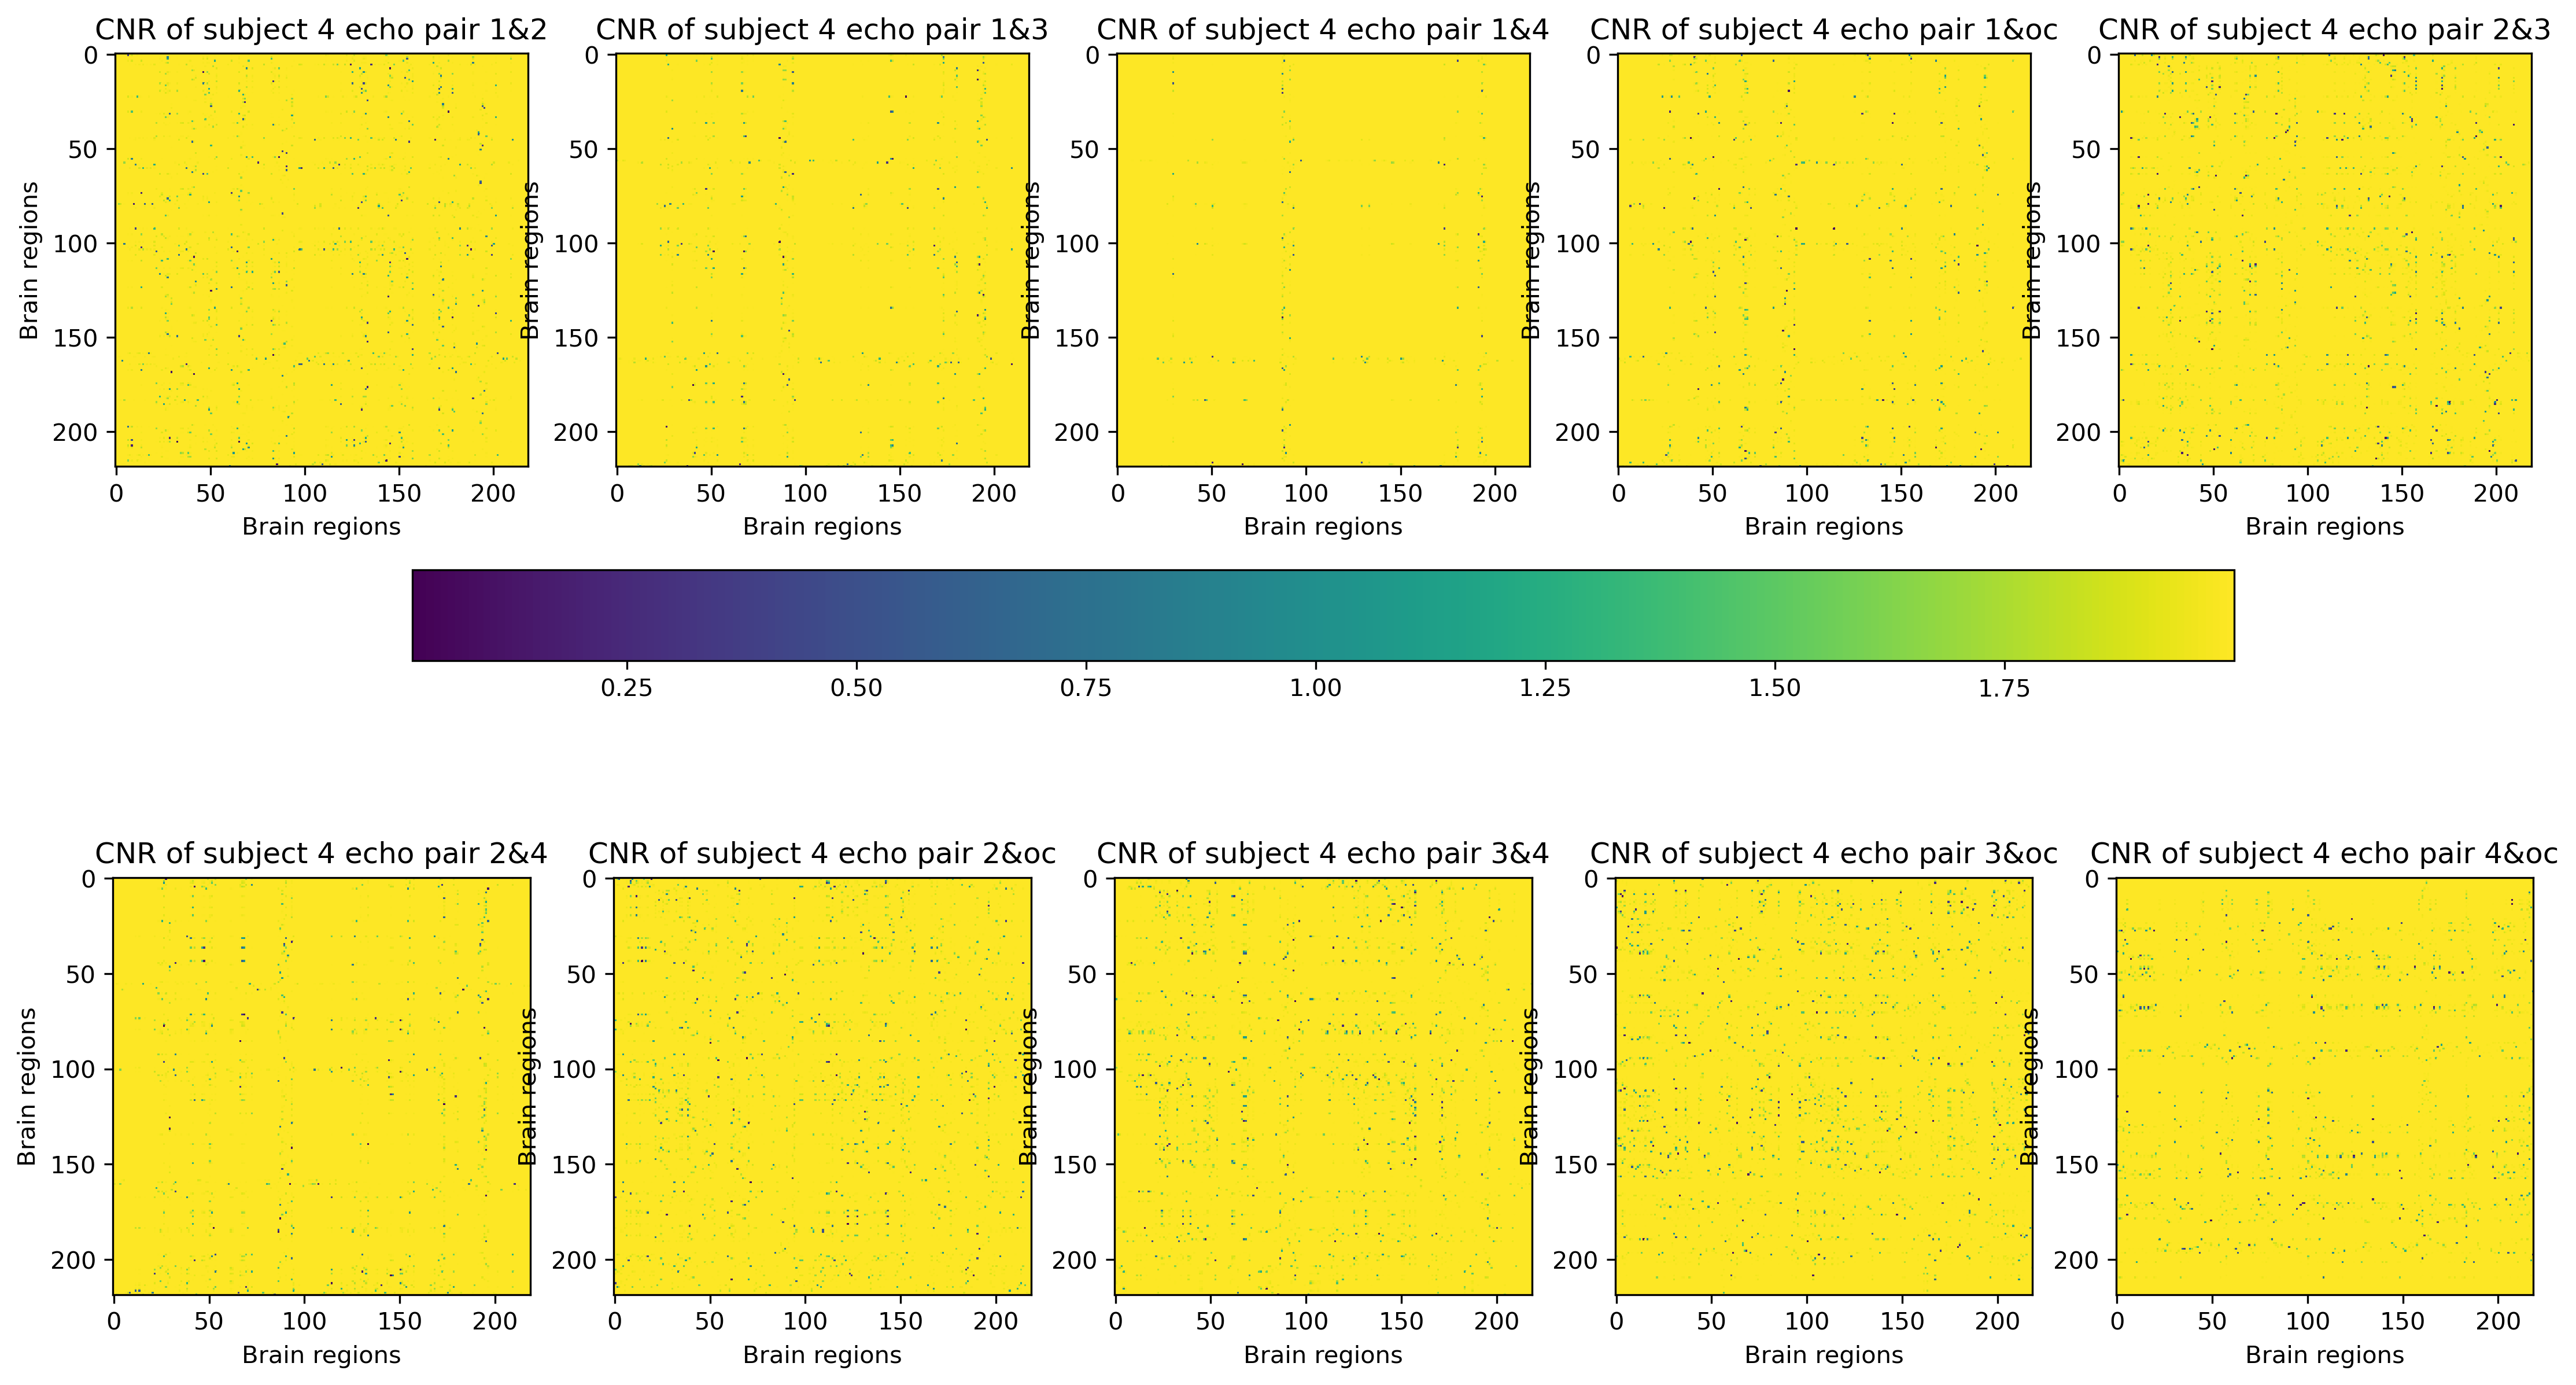

In [7]:
fig = plt.figure(dpi=300,figsize=(18,10))
ax1 = plt.subplot(251)
plt.title("CNR of subject 4 echo pair 1&2")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs_couple[0], vmin=0, vmax=2)
plt.imshow(CNRs_couple[0])

ax2 = plt.subplot(252)
plt.title("CNR of subject 4 echo pair 1&3")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs_couple[1], vmin=0, vmax=2)
plt.imshow(CNRs_couple[1])

ax3 = plt.subplot(253)
plt.title("CNR of subject 4 echo pair 1&4")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs_couple[2], vmin=0, vmax=2)
plt.imshow(CNRs_couple[2])

ax4 = plt.subplot(254)
plt.title("CNR of subject 4 echo pair 1&oc")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs_couple[3], vmin=0, vmax=2)
plt.imshow(CNRs_couple[3])

ax5 = plt.subplot(255)
plt.title("CNR of subject 4 echo pair 2&3")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs_couple[4], vmin=0, vmax=2)
plt.imshow(CNRs_couple[4])

ax6 = plt.subplot(256)
plt.title("CNR of subject 4 echo pair 2&4")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs_couple[5], vmin=0, vmax=2)
plt.imshow(CNRs_couple[5])

ax7 = plt.subplot(257)
plt.title("CNR of subject 4 echo pair 2&oc")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs_couple[6], vmin=0, vmax=2)
plt.imshow(CNRs_couple[6])

ax8 = plt.subplot(258)
plt.title("CNR of subject 4 echo pair 3&4")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs_couple[7], vmin=0, vmax=2)
plt.imshow(CNRs_couple[7])

ax9 = plt.subplot(259)
plt.title("CNR of subject 4 echo pair 3&oc")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs_couple[8], vmin=0, vmax=2)
plt.imshow(CNRs_couple[8])

ax10 = fig.add_subplot(2, 5, 10)
plt.title("CNR of subject 4 echo pair 4&oc")
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")
plt.pcolor(CNRs_couple[9], vmin=0, vmax=2)
plt.imshow(CNRs_couple[9])

plt.colorbar(ax=[ax1,ax2,ax3,ax4,ax5], pad=0.17, orientation='horizontal')

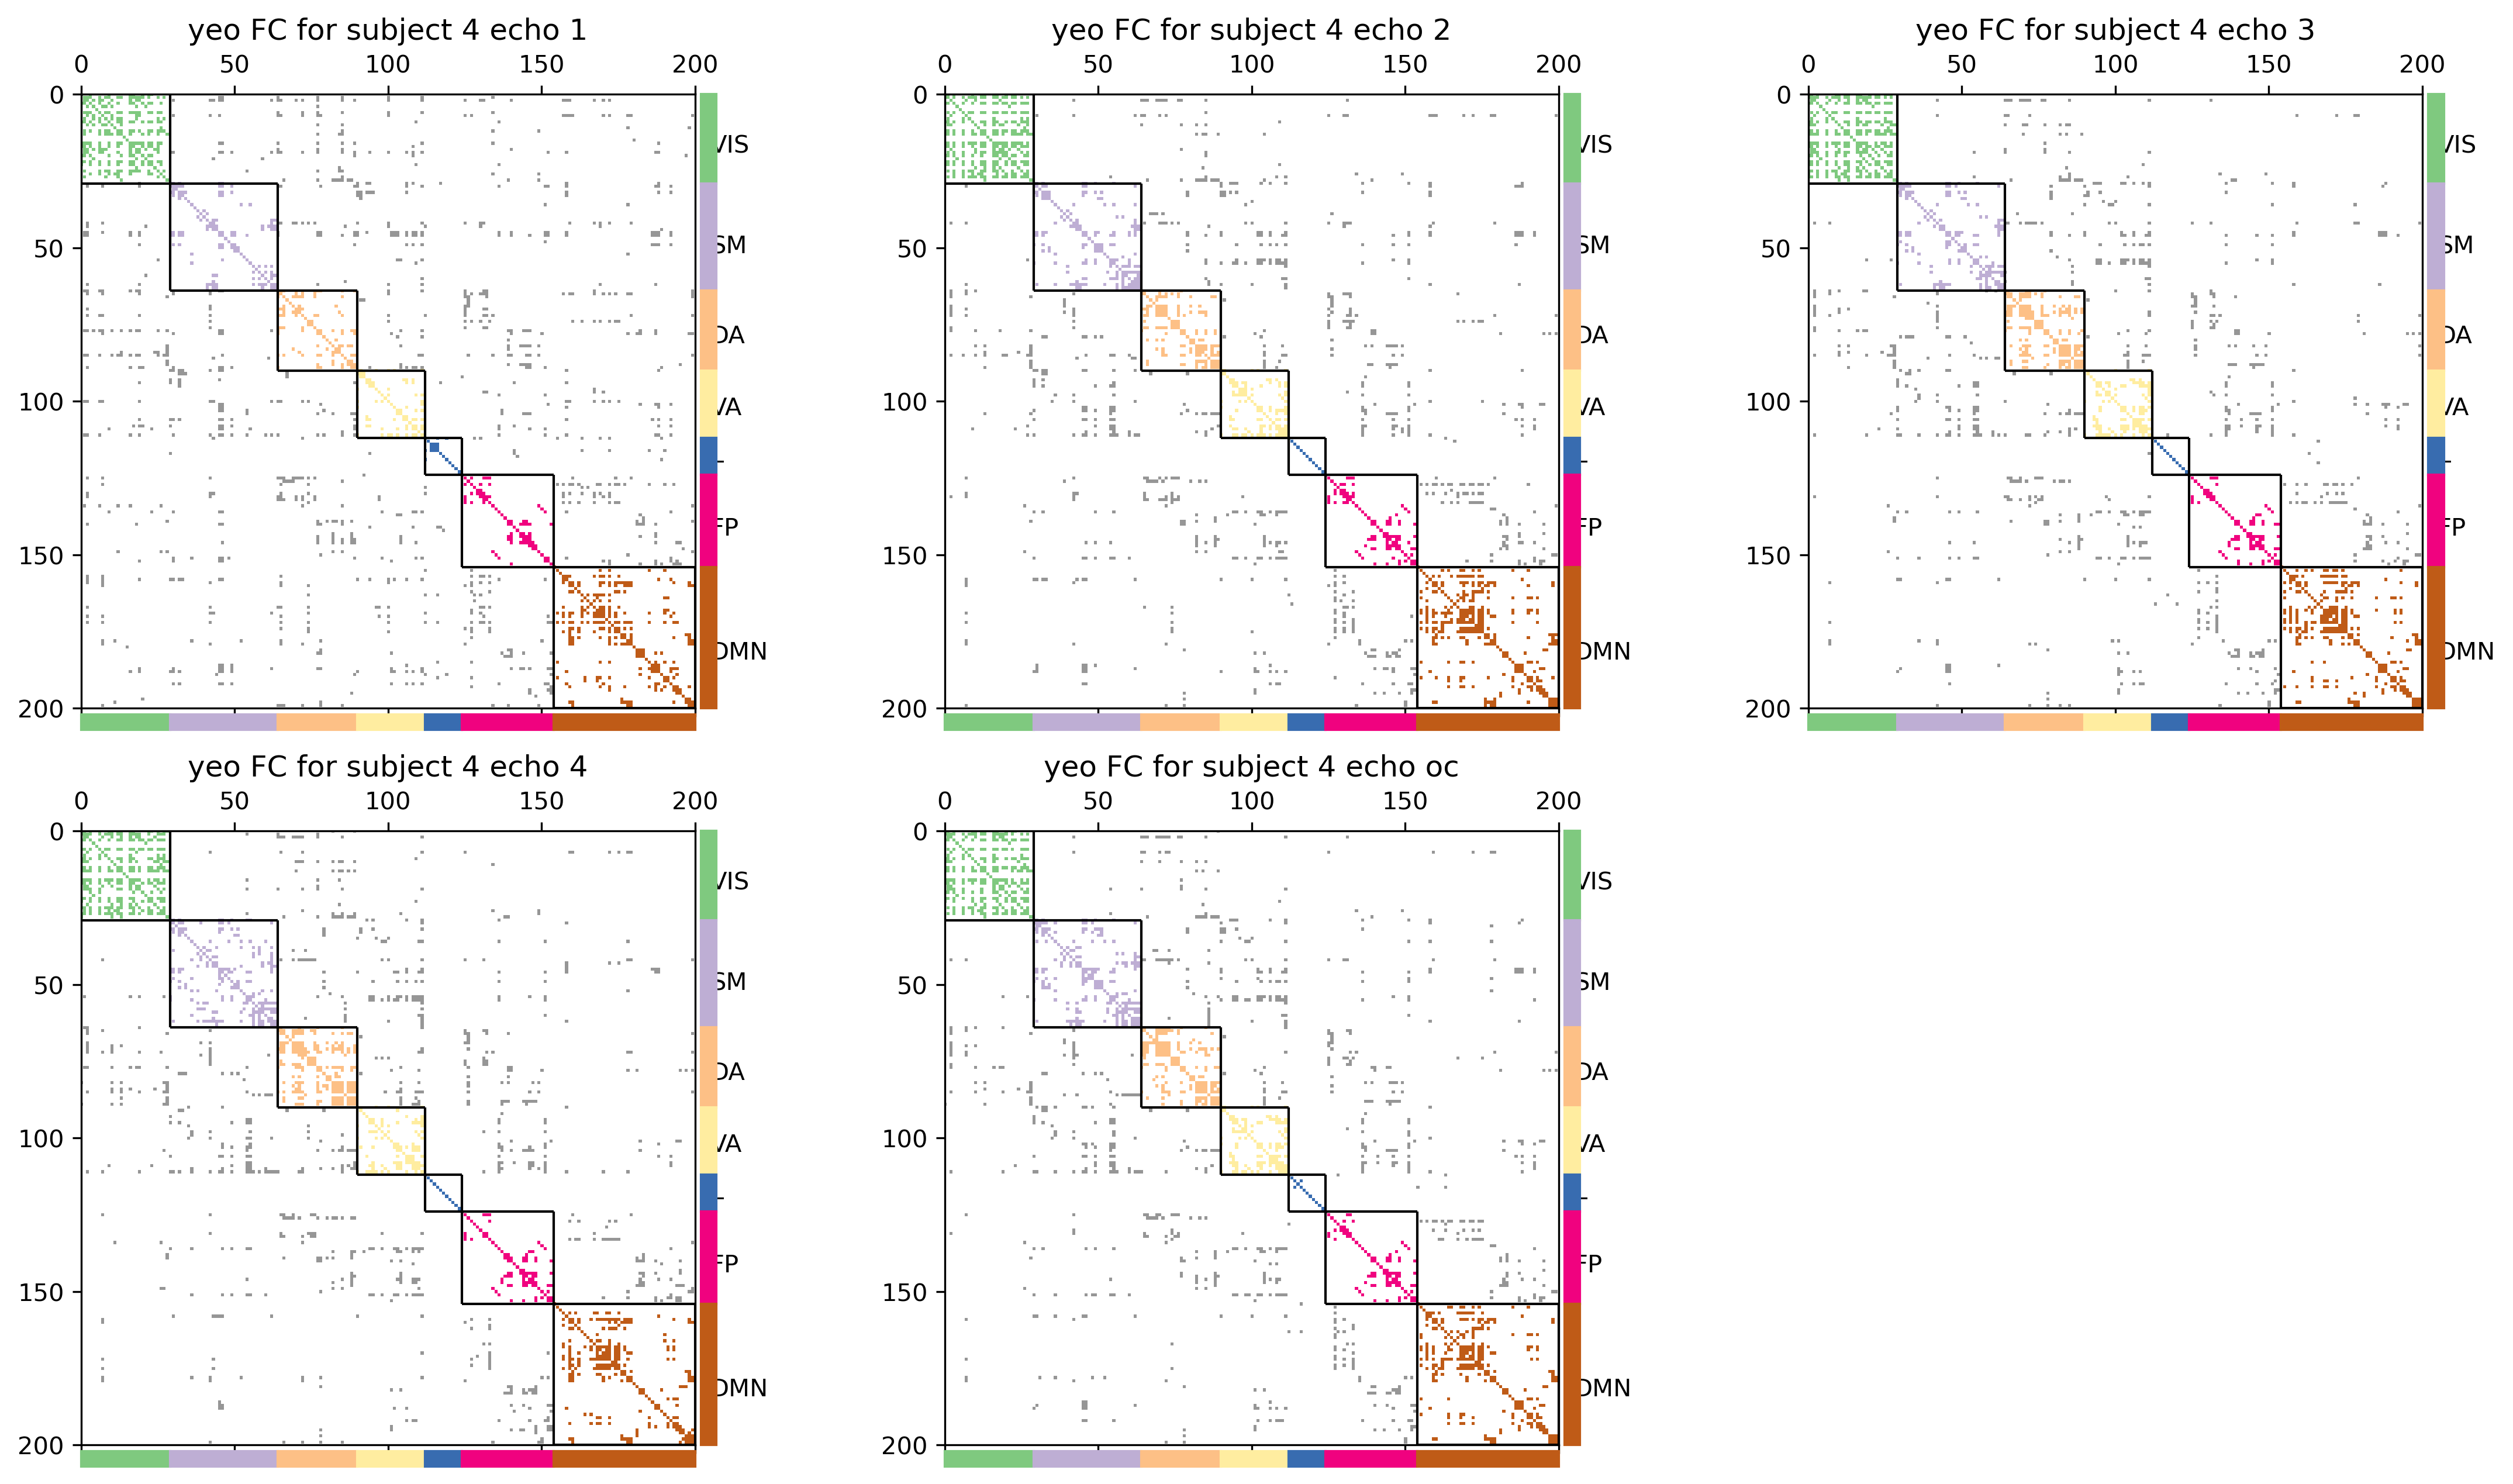

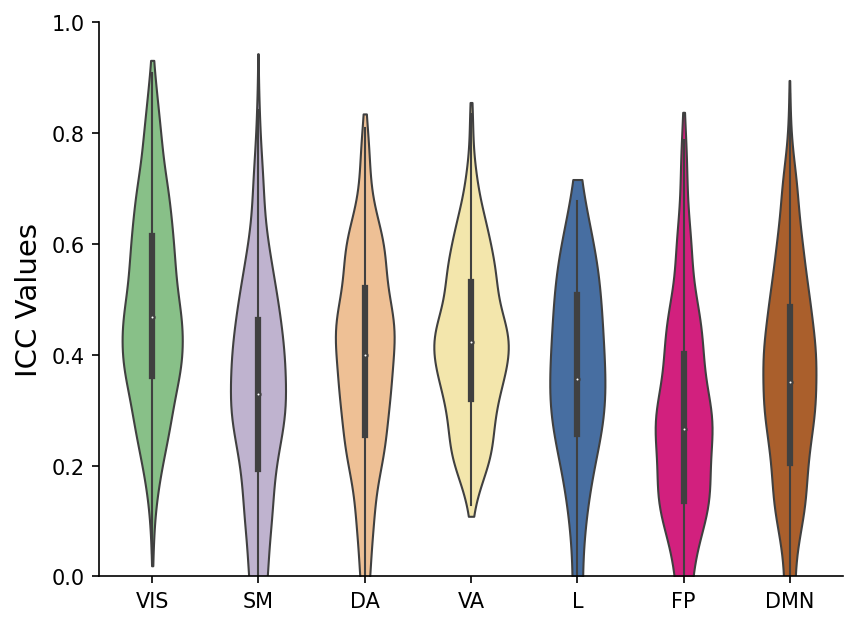

In [18]:
FCs_list = np.zeros((orig_matrixs_test.shape[0],orig_matrixs_test.shape[2],orig_matrixs_test.shape[1]))
for echo in range(TCs.shape[0]):
    # FCs_list[echo] = FCs_normalize(compute_FCs(TCs[echo]))
    FCs_list[echo] = compute_FCs(TCs[echo])
# FCs_list = FCs_list[:,3]

# draw_compare_links_with_different_echoes(result_path, FCs_list)

In [22]:
FCs_list.shape

(5, 23871)

In [21]:
FC_mats = []
for echo in range(5):
    FC_mats.append(FCs_list[echo])
FC_mats = np.array(FC_mats)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.53437645, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.43123542, 0.76155024, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.48692823, 0.73957097, 0.75838447, ..., 0.        , 0.        ,
        0.        ],
       [0.28492813, 0.57745432, 0.71722072, ..., 0.80182398, 0.        ,
        0.        ],
       [0.19564501, 0.21637941, 0.24059126, ..., 0.49490493, 0.59025457,
        0.        ]])

Text(0.5, 1.0, 'links difference between TE2 and TE4')

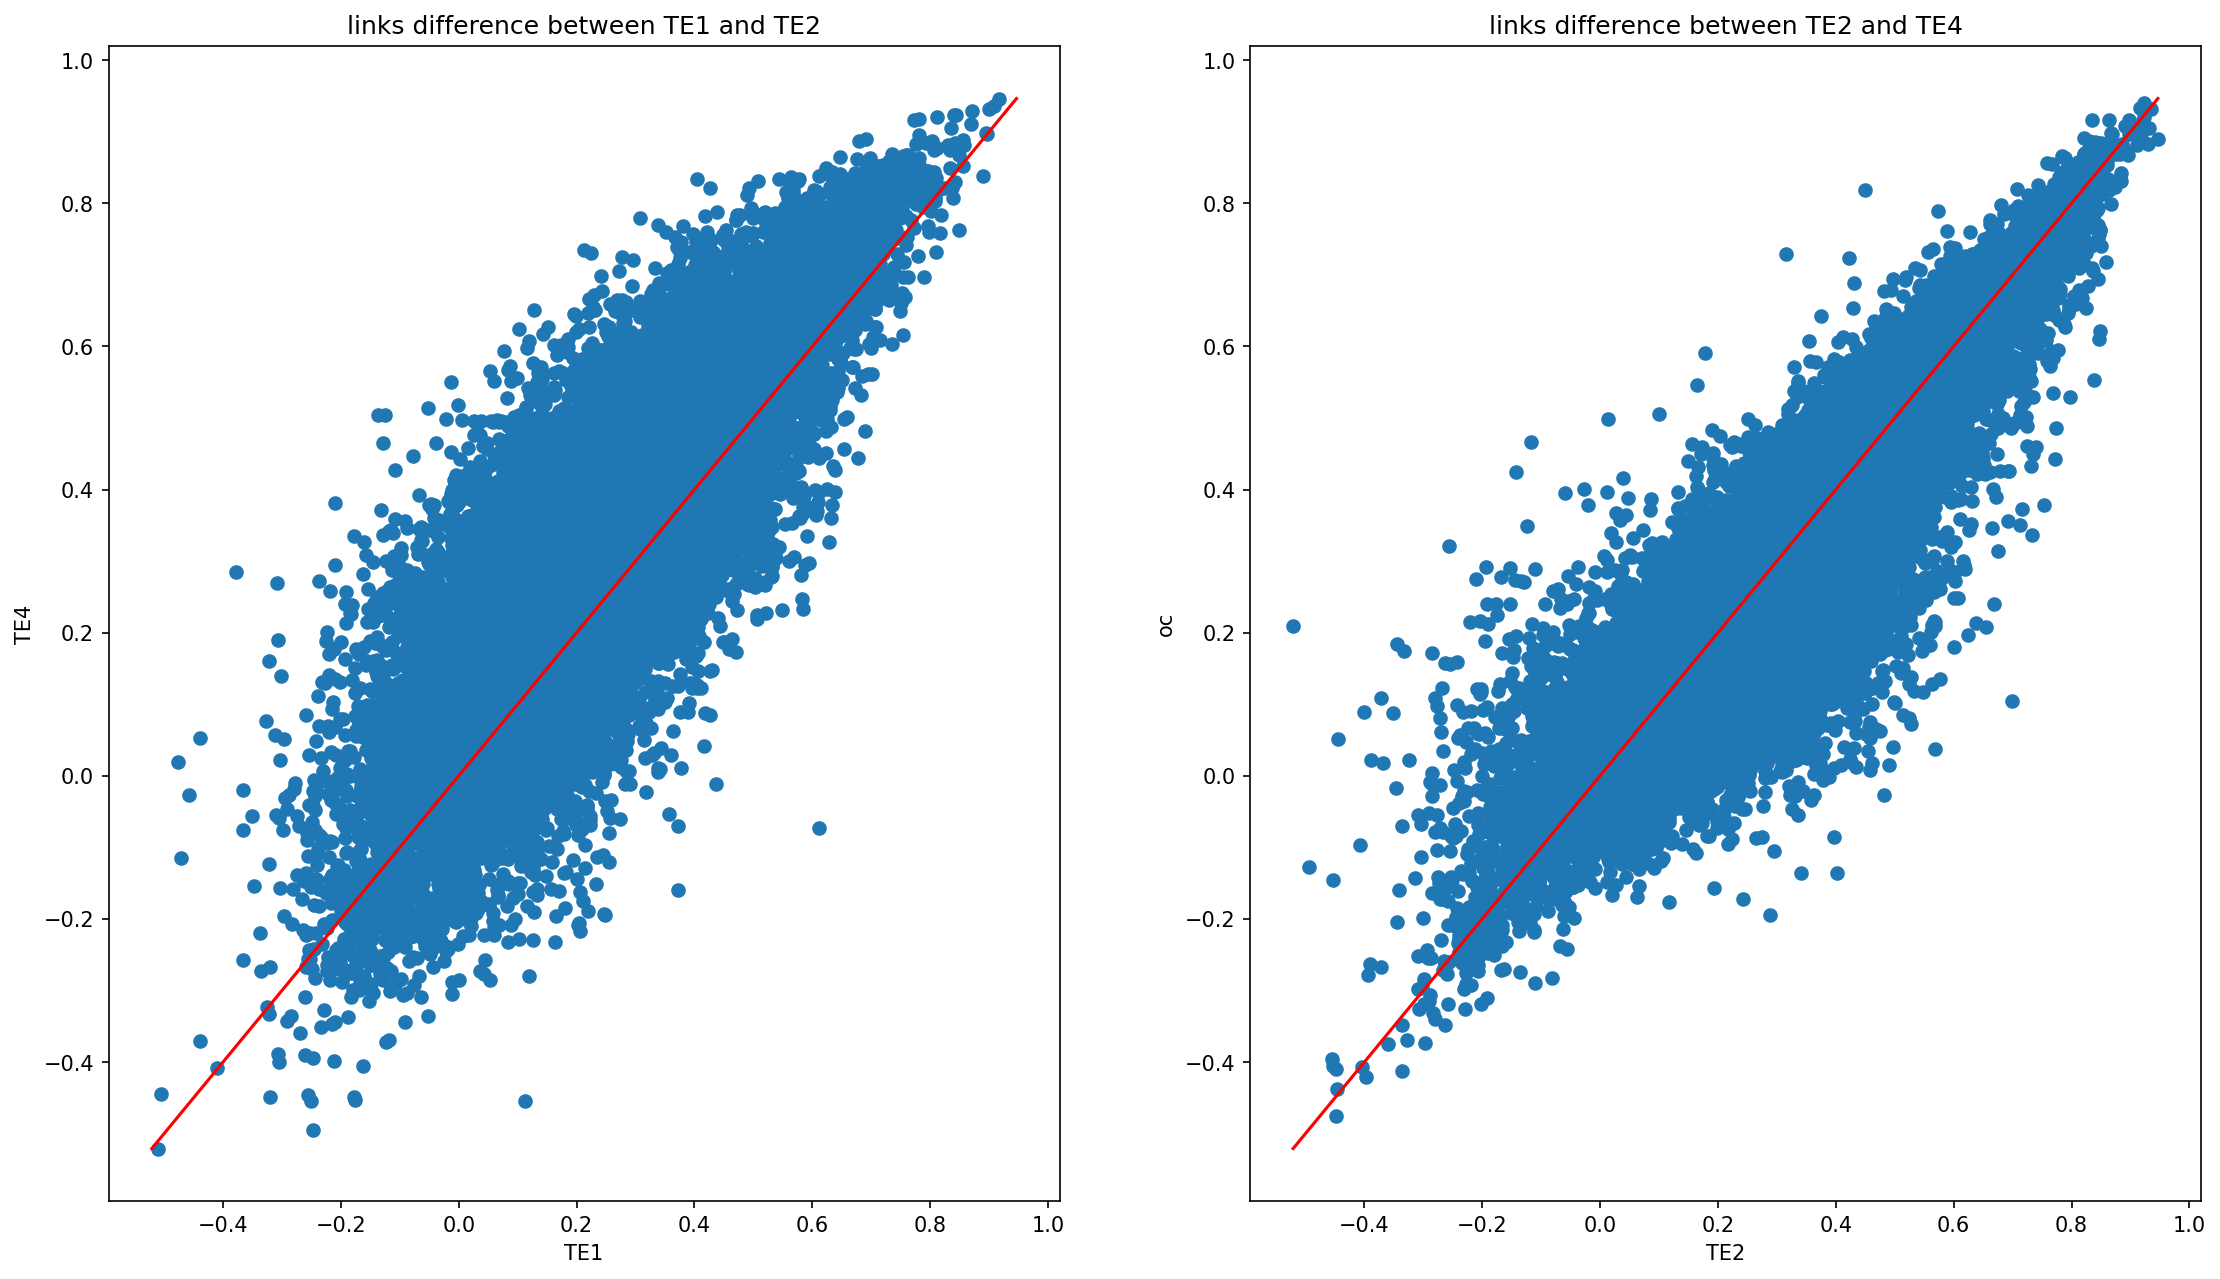

In [12]:
fig = plt.figure(dpi=150,figsize=(18,10))
ax= plt.subplot(121)
value_min = min(np.min(FCs_list[0]), np.min(FCs_list[1]))
value_max = max(np.max(FCs_list[0]), np.max(FCs_list[1]))
plt.plot([value_min, value_max],[value_min, value_max],'r-')
plt.scatter(FCs_list[0], FCs_list[1])
plt.xlabel('TE1')
plt.ylabel('TE4')
plt.title('links difference between TE1 and TE2')

ax= plt.subplot(122)
value_min = min(np.min(FCs_list[1]), np.min(FCs_list[3]))
value_max = max(np.max(FCs_list[1]), np.max(FCs_list[3]))
plt.plot([value_min, value_max],[value_min, value_max],'r-')
plt.scatter(FCs_list[1], FCs_list[3])
plt.xlabel('TE2')
plt.ylabel('oc')
plt.title('links difference between TE2 and TE4')

In [28]:
yeoOrder,limit_yeo=load_yeonets_matfile(filename="/media/miplab-nas2/Data3/Danyang/Multi-Echo-BOLD_fingerprinting/yeo_RS7_Schafer200S.mat")

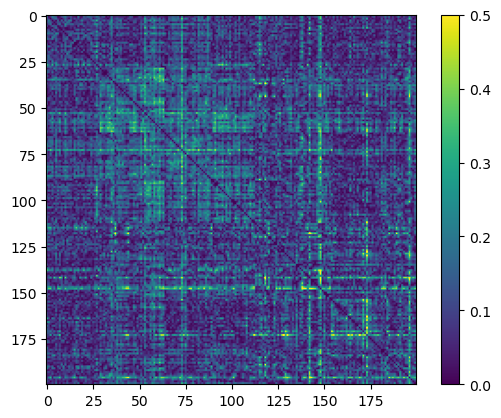

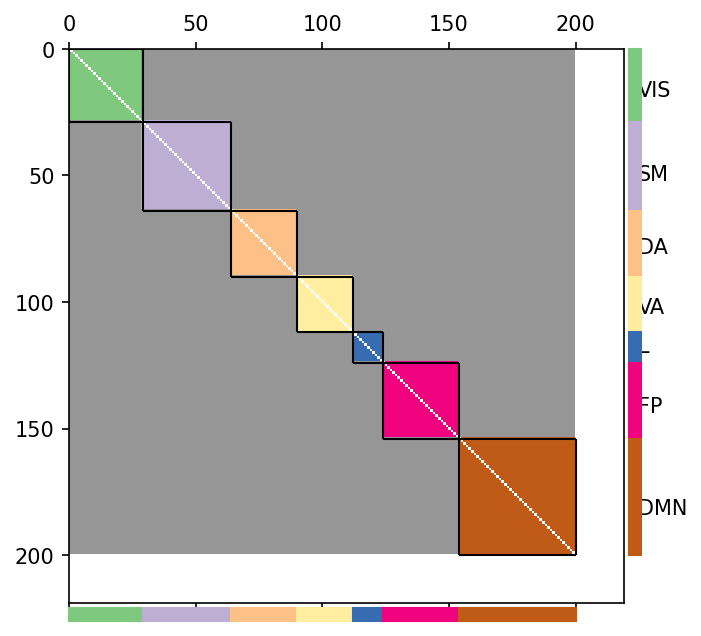

In [40]:
u,v=np.tril_indices(n=219,k=-1,m=219)
FC_mat_1=np.zeros((219,219))
FC_mat_1[u,v]=FCs_list[0]
FC_mat_1+=FC_mat_1.T


FC_mat_2=np.zeros((219,219))
FC_mat_2[u,v]=FCs_list[1]
FC_mat_2+=FC_mat_2.T


FC_mat_3=np.zeros((219,219))
FC_mat_3[u,v]=FCs_list[2]
FC_mat_3+=FC_mat_3.T

FC_mat_4=np.zeros((219,219))
FC_mat_4[u,v]=FCs_list[3]
FC_mat_4+=FC_mat_4.T


FC_mat_5=np.zeros((219,219))
FC_mat_5[u,v]=FCs_list[4]
FC_mat_5+=FC_mat_5.T

plt.imshow(np.abs(FC_mat_1-FC_mat_2)[yeoOrder,:][:,yeoOrder],vmin=0,vmax=0.5)
plt.colorbar()
plot_ICC_mat(np.abs(FC_mat_1-FC_mat_2),yeo_net=True,yeoOrder=yeoOrder, limit_yeo=limit_yeo,percentile=0  )

In [43]:
limit_yeo

{'VIS': [0, 29],
 'SM': [29, 64],
 'DA': [64, 90],
 'VA': [90, 112],
 'L': [112, 124],
 'FP': [124, 154],
 'DMN': [154, 200]}

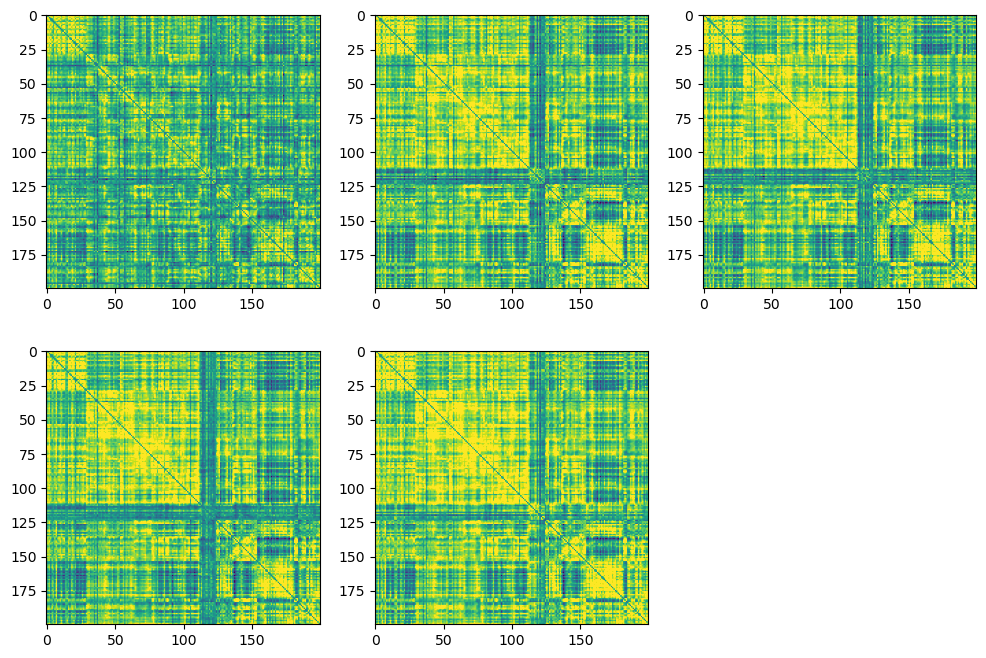

In [42]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(FC_mat_1[yeoOrder,:][:,yeoOrder],vmin=-0.4,vmax=0.6)

plt.subplot(232)
plt.imshow(FC_mat_2[yeoOrder,:][:,yeoOrder],vmin=-0.4,vmax=0.6)

plt.subplot(233)
plt.imshow(FC_mat_3[yeoOrder,:][:,yeoOrder],vmin=-0.4,vmax=0.6)

plt.subplot(234)
plt.imshow(FC_mat_4[yeoOrder,:][:,yeoOrder],vmin=-0.4,vmax=0.6)

plt.subplot(235)
plt.imshow(FC_mat_5[yeoOrder,:][:,yeoOrder],vmin=-0.4,vmax=0.6)
